# Identifying Peer Institutions in Higher Education
## A Machine Learning Approach




|                   |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
|-------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Project Members**           | tommaho                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| **Goal of Project**           | A model for determining Higher Education peer groups algorithmically, based on programs and degree levels offered.                                                                                                                                                                                                                                                                                                                                          |
| **Stakeholders**              | The Higher Education Institutional Research, Public Relations and Marketing, and Admissions communities.                                                                                                                                                                                                                                                                                                                                                                                     |
| **Description of Proposed Work** | In Institutional Research, we’re often tasked with identifying who we think our peers are for comparative and competitive analysis. This has become Tribal Knowledge over time but is not frequently tested, nor do we necessarily know who our peer’s peers are, or who the peers necessarily are for a subset of the institution.  <br><br>The proposed work is to explore unsupervised learning, clustering specifically, to determine which algorithms would be effective for determining peer groups based on the kinds of programs offered and portions of an institutions completers represented. A prototype tool will be developed using a Jupyter notebook to facilitate the data preparation, model exploration, and report generation. <br><br>This is an evolution of previous work I’ve done using simple ratio methods, available [here](https://secure.pct.edu/peers/), and (source) here. |
| **Data Set(s)**               | IPEDS Institutional Characteristics and Completions data available [here](https://nces.ed.gov/ipeds/datacenter/DataFiles.aspx?gotoReportId=7&fromIpeds=true&sid=83007a44-2e8e-4e37-aa91-1de95c529e6b&rtid=7) will be the primary sources for this work. The data sets used include: <br><br>  [2023 Institutional Characteristics - HD2023](https://nces.ed.gov/ipeds/datacenter/data/HD2023.zip)<br>[2023 Completions - C2023_A](https://nces.ed.gov/ipeds/datacenter/data/C2023_A.zip)<br><br>Resources for interpretation include:<br><br>[Institutional Characteristics Data Dictionary](https://nces.ed.gov/ipeds/datacenter/data/HD2023_Dict.zip)<br>[Completions Data Dictionary](https://nces.ed.gov/ipeds/datacenter/data/C2023_A_Dict.zip)<br>[CIP Code Lookup](https://nces.ed.gov/ipeds/cipcode/browse.aspx?y=55)                                                                                                                                       |
| **Constraints and/or Assumptions** | Preparing the data will require creativity. This work will rely heavily on Classification of Instructional Program (CIP) codes from IPEDS completions, which are structured hierarchically in 6 digits identifying field, subfield, and focus. This results in hundreds to thousands of program groups for even moderately sized institutions. Treating each of these as individual features will present some challenges, as I may need to account for not only programs offered but relative numbers of completes by program. |
| **Ethical Considerations**    | There should be few to no ethical considerations. It'll need to be made clear to any consumers of the output how it was generated: based solely on Instructional Program Codes (CIPs), award levels, and numbers of completers. Other peer methodologies use campus size, setting, and demographics.                                                                                                                                                                                                                                                                                                                                                                                                                                             |


# The Plan

----

### - Get IPEDS data files, Institutional Characteristics and Completions
### - Reduce to necessary fields
### - Pivot on Classification of Instructional Program (CIP) code, and apply clustering.

----

## Imports and config

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# duckdb for sql-on-dataframes
import duckdb

# chardet because I couldn't figure out the encoding of the IPEDS csv files.
import chardet

# PCA because how else do you visualize the features I'm working with?
from sklearn.decomposition import PCA

# I eventually end up vectorizing text
from sklearn.feature_extraction.text import TfidfVectorizer

# ..and using a similarity measure to find peers
from sklearn.metrics.pairwise import cosine_similarity

# for better formatting
from IPython.display import display, HTML


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)


## Data load and preview

In [8]:
# by default read_csv had errors and I needed to determine the file encoding
# via chardet

with open('notebook_data_in/hd2023.csv', 'rb') as f:
    result = chardet.detect(f.read(1000000))
    encoding = result['encoding']

display(HTML(f'<h3>Header File Encoding: {encoding}</h3>'))

In [9]:
ic_raw = pd.read_csv('notebook_data_in/hd2023.csv', encoding=encoding)
comp_raw = pd.read_csv('notebook_data_in/c2023_a.csv', encoding=encoding)

display(HTML(f'\n<h3>Characteristics has {len(ic_raw.columns)} columns.</h3><br>\n'))
display(ic_raw.head(5))

display(HTML(f'\n<h3>Completions has {len(comp_raw.columns)} columns.</h3><br>\n'))
display(comp_raw.head(5))

UNITID                               INSTNM  \
0  100654             Alabama A & M University   
1  100663  University of Alabama at Birmingham   
2  100690                   Amridge University   
3  100706  University of Alabama in Huntsville   
4  100724             Alabama State University   

                                              IALIAS  \
0                                               AAMU   
1                                                UAB   
2  Southern Christian University  Regions University   
3              UAH  University of Alabama Huntsville   
4                                                      

                             ADDR        CITY STABBR         ZIP  FIPS  \
0            4900 Meridian Street      Normal     AL       35762     1   
1  Administration Bldg Suite 1070  Birmingham     AL  35294-0110     1   
2                  1200 Taylor Rd  Montgomery     AL  36117-3553     1   
3                 301 Sparkman Dr  Huntsville     AL       35899     1   
4            915 S Jackson Street  Montgomery     AL  36104-0271     1   

   OBEREG               CHFNM   CHFTITLE         GENTELE        EIN  \
0       5  Dr. Daniel K. Wims  President      2563725000  636001109   
1       5        Ray L. Watts  President      2059344011  636005396   
2       5    Michael C.Turner  President  33438738777550  237034324   
3       5          Chuck Karr  President      2568246120  630520830   
4       5     Quinton T. Ross  President      3342294100  636001101   

           UEIS    OPEID  OPEFLAG                             WEBADDR  \
0  JDVGS67MSLH7   100200        1                       www.aamu.edu/   
1  YND4PLMC9AN7   105200        1                https://www.uab.edu/   
2  RB27R4GLDKE7  2503400        1  https://www.amridgeuniversity.edu/   
3  HB6KNGVNJRU1   105500        1                        www.uah.edu/   
4  DLJWLMSNK627   100500        1                      www.alasu.edu/   

                                         ADMINURL  \
0  https://www.aamu.edu/admissions-aid/index.html   
1                 https://www.uab.edu/admissions/   
2   https://www.amridgeuniversity.edu/admissions/   
3                  https://www.uah.edu/admissions   
4             www.alasu.edu/admissions/index.aspx   

                                                                          FAIDURL  \
0                              https://www.aamu.edu/admissions-aid/financial-aid/   
1                                                   https://www.uab.edu/cost-aid/   
2                                 https://www.amridgeuniversity.edu/financialaid/   
3                                                                 finaid.uah.edu/   
4  www.alasu.edu/undergraduate/expensesandfinancialaid/expenses-and-financial-aid   

                                                                         APPLURL  \
0  https://www.aamu.edu/admissions-aid/undergraduate-admissions/apply-today.html   
1                                           https://www.uab.edu/admissions/apply   
2                                   https://www.amridgeuniversity.edu/myamridge/   
3                                                              register.uah.edu/   
4                       www.alasu.edu/admissions/undergrad-admissions/index.aspx   

                                                                          NPRICURL  \
0               www.aamu.edu/admissions-aid/tuition-fees/net-price-calculator.html   
1  https://tcc.ruffalonl.com/University of Alabama at Birmingham/Freshman-Students   
2                                         https://www2.amridgeuniversity.edu:9091/   
3                                                                  finaid.uah.edu/   
4                        www.alasu.edu/cost-aid/tuition-costs/net-price-calculator   

                                                   VETURL  \
0                                                           
1                   https://www.uab.edu/students/veterans   
2  https://www.amri

UNITID  CIPCODE  MAJORNUM  AWLEVEL XCTOTALT  CTOTALT XCTOTALM  CTOTALM  \
0  100654   1.0999         1        5        R       18        R        1   
1  100654   1.1001         1        5        R        8        R        2   
2  100654   1.1001         1        7        R        6        R        2   
3  100654   1.1001         1       17        R        2        R        2   
4  100654   1.9999         1        5        R        2        Z        0   

  XCTOTALW  CTOTALW XCAIANT  CAIANT XCAIANM  CAIANM XCAIANW  CAIANW XCASIAT  \
0        R       17       R       0       R       0       R       0       R   
1        R        6       R       0       R       0       R       0       R   
2        R        4       R       0       R       0       R       0       R   
3        R        0       R       0       R       0       R       0       R   
4        R        2       Z       0       Z       0       Z       0       Z   

   CASIAT XCASIAM  CASIAM XCASIAW  CASIAW XCBKAAT  CBKAAT XCBKAAM  CBKAAM  \
0       0       R       0       R       0       R      14       R       1   
1       0       R       0       R       0       R       7       R       2   
2       0       R       0       R       0       R       3       R       1   
3       0       R       0       R       0       R       1       R       1   
4       0       Z       0       Z       0       R       1       Z       0   

  XCBKAAW  CBKAAW XCHISPT  CHISPT XCHISPM  CHISPM XCHISPW  CHISPW XCNHPIT  \
0       R      13       R       0       R       0       R       0       R   
1       R       5       R       0       R       0       R       0       R   
2       R       2       R       0       R       0       R       0       R   
3       R       0       R       0       R       0       R       0       R   
4       R       1       Z       0       Z       0       Z       0       Z   

   CNHPIT XCNHPIM  CNHPIM XCNHPIW  CNHPIW XCWHITT  CWHITT XCWHITM  CWHITM  \
0       0       R       0       R       0       R       1       R       0   
1       0       R       0       R       0       R       0       R       0   
2       0       R       0       R       0       R       0       R       0   
3       0       R       0       R       0       R       0       R       0   
4       0       Z       0       Z       0       R       1       Z       0   

  XCWHITW  CWHITW XC2MORT  C2MORT XC2MORM  C2MORM XC2MORW  C2MORW XCUNKNT  \
0       R       1       R       1       R       0       R       1       R   
1       R       0       R       0       R       0       R       0       R   
2       R       0       R       0       R       0       R       0       R   
3       R       0       R       0       R       0       R       0       R   
4       R       1       Z       0       Z       0       Z       0       Z   

   CUNKNT XCUNKNM  CUNKNM XCUNKNW  CUNKNW XCNRALT  CNRALT XCNRALM  CNRALM  \
0       2       R       0       R       2       R       0       R       0   
1       1       R       0       R       1       R       0       R       0   
2       0       R       0       R       0       R       3       R       1   
3       0       R       0       R       0       R       1       R       1   
4       0       Z       0       Z       0       Z       0       Z       0   

  XCNRALW  CNRALW    
0       R         0  
1       R         0  
2       R         2  
3       R         0  
4       Z         0

## Combine and reduce data

A sum of ctotalt is taken, because multiple records can be reported
for the same CIP and award level when earned as a non-primary degree.

OPEFLAG = 1, eligible for title IV aid  
GROFFER = 1, offers undergraduate degrees  
ACT = 'A', institution is active in IPEDS and can be expected to have completer data

In [11]:
# DuckDB is so worth it. 
# https://duckdb.org/

df = duckdb.sql("""
select
ic.unitid 
, cipcode as cip_code
, awlevel as award_level
, sum(ctotalt) as completers
from ic_raw ic
join comp_raw comp
    on comp.unitid = ic.unitid
where opeflag = 1
    and groffer = 1
    and trim(act) = 'A'
group by ic.unitid, instnm, stabbr, cipcode, awlevel, act
""").df()

df.head(10)

UNITID  cip_code  award_level  completers
0  210775   54.0101            5         3.0
1  211130   42.2803            7        14.0
2  211273    3.0103            5        10.0
3  211273   16.0104            5         1.0
4  211273   26.0210            5         7.0
5  211273   27.0101            7         5.0
6  211273   38.0101            5         9.0
7  211273   40.0801           17         1.0
8  211273   42.2899           17         0.0
9  211273   45.0301            5         3.0

### Double check data quality

IPEDS / NCES doesn't accept data that isn't perfect, and even performs checks on accepted data. It wouldn'd be made available to download unless it's been verified. That said, I'll double check:

In [13]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171080 entries, 0 to 171079
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UNITID       171080 non-null  int64  
 1   cip_code     171080 non-null  float64
 2   award_level  171080 non-null  int64  
 3   completers   171080 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 5.2 MB


## Pivoting

In [15]:
df_pivot = df.pivot_table(
    index='UNITID', 
    columns=['cip_code', 'award_level'], 
    values='completers', 
    fill_value=0
)

display(HTML(f"\n<h3>Pivoted data has {len(df_pivot.columns)} columns!</h3><br>\n"))

df_pivot.head()

cip_code    1.0000                                1.0101                       \
award_level      3    4    5    6    7    17   21      2    3    4    5    6    
UNITID                                                                          
100654          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100663          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100690          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100706          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100724          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   

cip_code                   1.0102                           1.0103             \
award_level   7    17   21      2    3    5    6    7    21      5    7    17   
UNITID                                                                          
100654       0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   
100663       0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   
100690       0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   
100706       0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   
100724       0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   

cip_code         1.0104            1.0105       1.0106  1.0199             \
award_level   21      2    5    7       3    5       5       3    4    5    
UNITID                                                                      
100654       0.0     0.0  0.0  0.0     0.0  0.0     0.0     0.0  0.0  0.0   
100663       0.0     0.0  0.0  0.0     0.0  0.0     0.0     0.0  0.0  0.0   
100690       0.0     0.0  0.0  0.0     0.0  0.0     0.0     0.0  0.0  0.0   
100706       0.0     0.0  0.0  0.0     0.0  0.0     0.0     0.0  0.0  0.0   
100724       0.0     0.0  0.0  0.0     0.0  0.0     0.0     0.0  0.0  0.0   

cip_code                   1.0201                 1.0205            1.0299   \
award_level   6    7    21      3    5    6    21      2    3    5       5    
UNITID                                                                        
100654       0.0  0.0  0.0     0.0  0.0  0.0  0.0     0.0  0.0  0.0     0.0   
100663       0.0  0.0  0.0     0.0  0.0  0.0  0.0     0.0  0.0  0.0     0.0   
100690       0.0  0.0  0.0     0.0  0.0  0.0  0.0     0.0  0.0  0.0     0.0   
100706       0.0  0.0  0.0     0.0  0.0  0.0  0.0     0.0  0.0  0.0     0.0   
100724       0.0  0.0  0.0     0.0  0.0  0.0  0.0     0.0  0.0  0.0     0.0   

cip_code         1.0301                                1.0302                  \
award_level   21      2    3    5    6    7    17   21      3    5    6    21   
UNITID                                                                          
100654       0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
100663       0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
100690       0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
100706       0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   
100724       0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   

cip_code    1.0303                                1.0304                       \
award_level      3    5    6    7    17   20   21      2    3    5    6    21   
UNITID                                                                          
100654          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100663          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100690          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100706          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   
100724          0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   

cip_code    1.0306            1.0307                           1.0308        \
award_level      3    5    21      2    3    5    6    7    21      2    3 

## Scaling

In [17]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_pivot)

## K-means Clustering

In [19]:
kmeans = KMeans(n_clusters=25, random_state=42, n_init="auto") 
labels = kmeans.fit_predict(scaled_df)

# Add cluster labels back to the DataFrame
df_pivot['cluster'] = labels

In [20]:
print(df_pivot['cluster'].value_counts())

cluster
1     1976
22       1
12       1
23       1
11       1
9        1
16       1
15       1
20       1
7        1
21       1
0        1
13       1
4        1
18       1
17       1
8        1
6        1
24       1
19       1
5        1
10       1
14       1
2        1
3        1
Name: count, dtype: int64


## That's not good. Use elbow method to try to find an optimal number of clusters.

### Hint: the elbow never happens, or I dont have the computing power to find it.

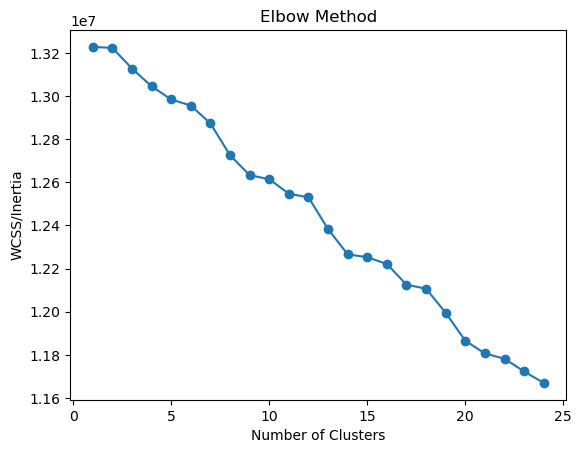

In [22]:
wcss = []

for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, random_state=5, n_init='auto')
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.plot(range(1, 25), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS/Inertia')
plt.show()

## How to visualize with so many features? 

## Principal Component Analysis (PCA)?

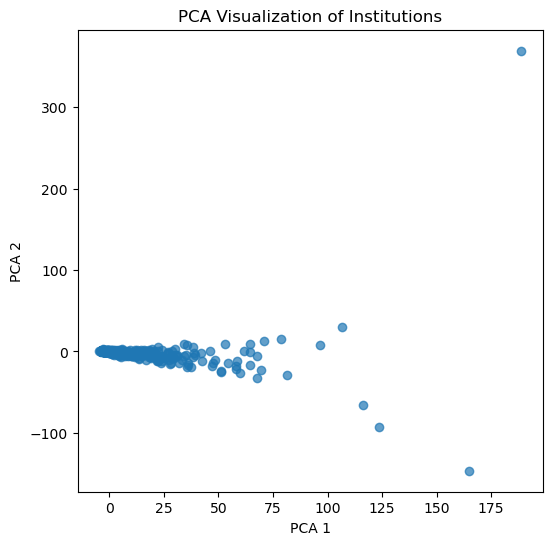

In [24]:
# Reduce via PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)

plt.figure(figsize=(6, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7)
plt.title('PCA Visualization of Institutions')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


### If a solution does exist in this method of clustering, I don't have the computing power to find it.

<br><br><br>

# New Plan:

# Identifying Peer Institutions in Higher Education
## A ~~Machine Learning~~ Natural Language Processing Approach

  

  

# 

## ToDo

----

### - ...
### - Convert completions to a body of text, vectorize, and use a similarity measure.


## What I have to work with

In [29]:
df_pivot.reset_index() 

cip_code     UNITID  1.0                               1.0101                 \
award_level            3    4    5    6    7   17   21      2    3    4    5   
0            100654  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
1            100663  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
2            100690  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
3            100706  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
4            100724  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
...             ...  ...  ...  ...  ...  ...  ...  ...    ...  ...  ...  ...   
1995         497480  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
1996         497693  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
1997         497718  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
1998         498562  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   
1999         498571  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0   

cip_code                        1.0102                          1.0103       \
award_level    6    7   17   21      2    3    5    6    7   21      5    7   
0            0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
1            0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
2            0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
3            0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
4            0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
...          ...  ...  ...  ...    ...  ...  ...  ...  ...  ...    ...  ...   
1995         0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
1996         0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
1997         0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
1998         0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   
1999         0.0  0.0  0.0  6.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0   

cip_code              1.0104           1.0105      1.0106 1.0199            \
award_level   17   21      2    5    7      3    5      5      3    4    5   
0            0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
1            0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
2            0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
3            0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
4            0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
...          ...  ...    ...  ...  ...    ...  ...    ...    ...  ...  ...   
1995         0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
1996         0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
1997         0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
1998         0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   
1999         0.0  0.0    0.0  0.0  0.0    0.0  0.0    0.0    0.0  0.0  0.0   

cip_code                   1.0201                1.0205           1.0299       \
award_level    6    7   21      3    5    6   21      2    3    5      5   21   
0            0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
1            0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
2            0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
3            0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
4            0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
...          ...  ...  ...    ...  ...  ...  ...    ...  ...  ...    ...  ...   
1995         0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
1996         0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
1997         0.0  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
1998         0.0  0.0  0.

### Unpivoted, that looks like:

In [31]:

df_nlp_base = df[['UNITID', 'cip_code', 'award_level', 'completers']].copy()

df_nlp_base

UNITID  cip_code  award_level  completers
0       210775   54.0101            5         3.0
1       211130   42.2803            7        14.0
2       211273    3.0103            5        10.0
3       211273   16.0104            5         1.0
4       211273   26.0210            5         7.0
...        ...       ...          ...         ...
171075  209825    5.0125            5         4.0
171076  209825   13.0101            7        84.0
171077  209825   50.0901            5         6.0
171078  209825   52.1301            7         2.0
171079  201645   54.0101            5        15.0

[171080 rows x 4 columns]

## I want to convert the data to text, as:

###  (cip_code + '-' + award_level) * completers

In [33]:
new_types = {
    'cip_code': str,
    'award_level': str,
    'completers': int,
}

for column, dtype in new_types.items():
    df_nlp_base[column] = df_nlp_base[column].astype(dtype)

    
df_nlp_base['text'] = (
    (df_nlp_base['cip_code'] + '-' + df_nlp_base['award_level']) + ' ') * df_nlp_base['completers']

df_nlp_base.head(5)

UNITID cip_code award_level  completers  \
0  210775  54.0101           5           3   
1  211130  42.2803           7          14   
2  211273   3.0103           5          10   
3  211273  16.0104           5           1   
4  211273   26.021           5           7   

                                                                                                                                           text  
0                                                                                                                54.0101-5 54.0101-5 54.0101-5   
1  42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7   
2                                                    3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5   
3                                                                                                                                    16.0104-5   
4                                                                               26.021-5 26.021-5 26.021-5 26.021-5 26.021-5 26.021-5 26.021-5

### A UNITID will have many rows, so combine them into single bodies of text.

In [35]:
to_text = {}

for i, row in df_nlp_base.iterrows():
    unitid = row['UNITID']
    text = row['text']
  
    if unitid in to_text:
        to_text[unitid]['Text'] += text
    else:
        to_text[unitid] = {'Text': text}    
    
df_prepared = pd.DataFrame(to_text).transpose().reset_index().rename(columns={'index':'UNITID'})

df_prepared

UNITID  \
0     210775   
1     211130   
2     211273   
3     211291   
4     211352   
...      ...   
1995  215619   
1996  447801   
1997  451510   
1998  483975   
1999  439394   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Text  
0     54.0101-5 54.0101-5 54.0101-5 13.1001-7 13.1001-7 13.1001-7 13.1001-7 13.1001-7 13.1001-7 13.1001-7 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 43.0103-5 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.0-3 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51.2306-7 51...  
1                                                                                                 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 42.2803-7 39.0201-6 42.9999-6 42.9999-6 42.9999-6 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 99.0-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0699-7 39.0602-18 39.0602-18 39.0602-18 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 39.0602-7 99.0-18 99.0-18 99.0-18 39.0601-7 39.0601-7 39.0601-7 39.0601-7 39.0601-7 39.0601-7 39.0601-7 39.0601-7 39.0601-7 99.0-6 99.0-6 99.0-6 99.0-6   
2     3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 3.0103-5 16.0104-5 26.021-5 26.021-5 26.021-5 26.021-5 26.021-5 26.021-5 26.021-5 27.0101-7 27.0101-7 27.0101-7 27.0101-7 27.0101-7 38.0101-5 38.0101-5 38.0101-5 38.0101-5 38.0101-5 38.0101-5 38.0101-5 38.0101-5 38.0101-5 40.0801-17 45.0301-5 45.0301-5 45.0301-5 50.0703-5 50.0703-5 50.0703-5 50.0703-5 50.0703-5 50.0703-5 50.0703-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 11.0701-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5 27.0101-5

### Vectorize text

#### No stemming, stopping, or lemmatizing. These aren't "normal" words.

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_prepared['Text'])


### Calculate cosine similarity scores, and display the result as a dataframe

Cosine Similarity is a normalized dot product of vectors. 1 means they're identical, 0 means they're orthogonal (have nothing in common).

In [39]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim)
display(cosine_sim_df)

0         1         2         3         4         5         6     \
0     1.000000  0.340799  0.715155  0.653932  0.699430  0.598745  0.855354   
1     0.340799  1.000000  0.359414  0.368380  0.342904  0.315764  0.337662   
2     0.715155  0.359414  1.000000  0.828348  0.758662  0.676868  0.743953   
3     0.653932  0.368380  0.828348  1.000000  0.785274  0.776426  0.696571   
4     0.699430  0.342904  0.758662  0.785274  1.000000  0.641350  0.734096   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.176556  0.499809  0.187600  0.185557  0.184090  0.171450  0.178755   
1996  0.410284  0.124308  0.274173  0.230970  0.234612  0.224095  0.363984   
1997  0.268567  0.158917  0.238501  0.221763  0.218876  0.154209  0.237875   
1998  0.415491  0.172668  0.204946  0.172652  0.175374  0.160931  0.326783   
1999  0.228066  0.069585  0.153475  0.129291  0.131330  0.120514  0.203749   

          7         8         9         10        11        12        13    \
0     0.716768  0.677738  0.332994  0.710547  0.679462  0.849323  0.744660   
1     0.274415  0.483746  0.188354  0.445478  0.374257  0.375355  0.347580   
2     0.580373  0.714327  0.378687  0.737675  0.885890  0.772632  0.596530   
3     0.568533  0.697314  0.384371  0.761196  0.909408  0.821982  0.560586   
4     0.620040  0.752045  0.375292  0.837149  0.809973  0.768056  0.592147   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.149864  0.178663  0.104323  0.211199  0.193851  0.195423  0.146248   
1996  0.291323  0.223317  0.129855  0.244064  0.241294  0.334251  0.289232   
1997  0.179628  0.278397  0.089338  0.183278  0.266676  0.385760  0.556774   
1998  0.217766  0.264877  0.097068  0.182440  0.180369  0.425813  0.650293   
1999  0.163075  0.125007  0.072690  0.136621  0.135070  0.187105  0.161905   

          14        15        16        17        18        19        20    \
0     0.469086  0.780159  0.889007  0.838896  0.804589  0.809883  0.759881   
1     0.871113  0.387122  0.357818  0.353363  0.369705  0.338274  0.482974   
2     0.475488  0.607894  0.726632  0.700013  0.800520  0.743166  0.803007   
3     0.471743  0.571709  0.673169  0.668756  0.785026  0.760198  0.841796   
4     0.518065  0.566406  0.743063  0.705980  0.853335  0.797437  0.867408   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.467041  0.147129  0.177125  0.173916  0.194502  0.182760  0.247352   
1996  0.169740  0.378613  0.383148  0.339637  0.310116  0.289465  0.270324   
1997  0.112805  0.634247  0.278093  0.513316  0.258195  0.222222  0.234790   
1998  0.126882  0.729858  0.388851  0.559249  0.272283  0.241264  0.202069   
1999  0.095016  0.158287  0.214477  0.190120  0.173595  0.162035  0.151321   

          21        22        23        24        25        26        27    \
0     0.657082  0.469485  0.822382  0.830409  0.520153  0.828282  0.800186   
1     0.355671  0.217301  0.328833  0.406695  0.349545  0.293544  0.375412   
2     0.823154  0.457441  0.632904  0.718330  0.519015  0.626962  0.844242   
3     0.836306  0.435731  0.601297  0.677122  0.527949  0.570630  0.842705   
4     0.764060  0.502336  0.712742  0.802825  0.651026  0.703214  0.884854   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.187546  0.118480  0.160804  0.180201  0.192285  0.157608  0.201081   
1996  0.233447  0.136526  0.347930  0.335080  0.183894  0.348385  0.295362   
1997  0.204263  0.145250  0.190580  0.261327  0.131910  0.146330  0.236881   
1998  0.174503  0.102054  0.291994  0.347709  0.142836  0.260420  0.233994   
1999  0.130678  0.076424  0.194762  0.187569  0.102939  0.195017  0.165336   

          28        29        30        31        32        33        34    \
0     0.912978  0.731905  0.679186  0.860742  0.723742  0.858446  0.484115   
1     0.362298  0.384917  0.344690  0.360887  0.395171  0.326544  0.806703   
2     0.708438  0.868188  0.

### Visualized as a heatmap (abridged)

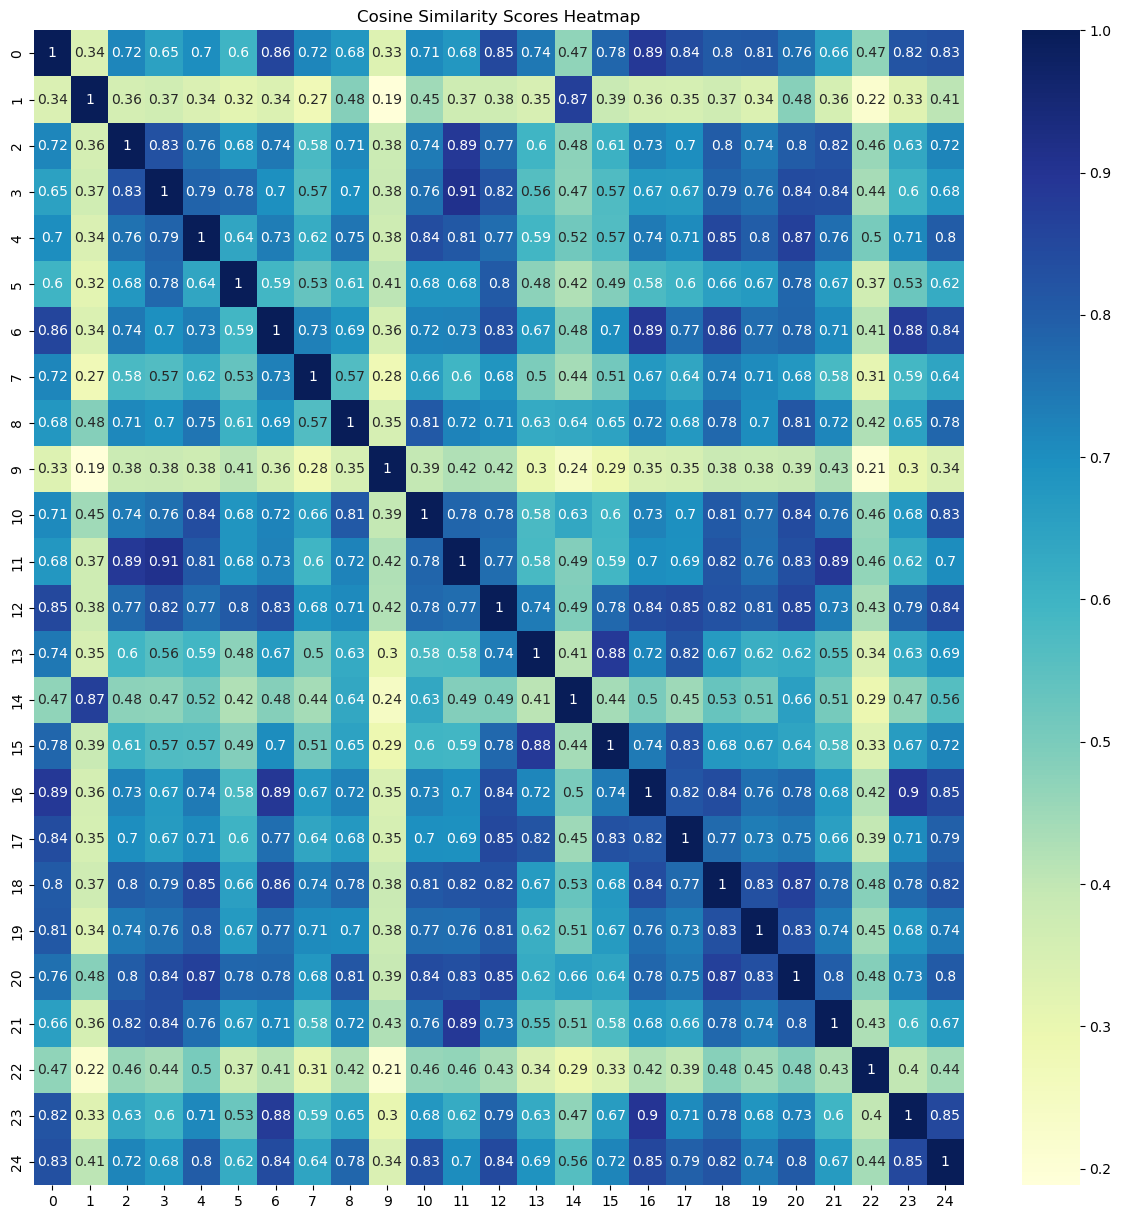

In [41]:
plt.figure(figsize=(15, 15))
sns.heatmap(cosine_sim_df.iloc[:25, :25], annot=True, cmap="YlGnBu", cbar=True)
plt.title("Cosine Similarity Scores Heatmap")
plt.show()

### Use the matrix to generate a Peer Report (extended with some data from the original Characteristics data)

In [43]:
# PCT = 366252
# NEIT = 217305
# Idaho State = 142276

unitid = 366252

# Get the index for PCT
unitid_loc = df_prepared[df_prepared['UNITID'] == unitid].index[0]

# Filter & sort 
similarities = cosine_sim_df[unitid_loc]
similar_institutions = similarities.sort_values(ascending=False)


# Add some convenience fields to the report
report = pd.DataFrame(similar_institutions).reset_index().rename(columns={'index':'orig_index'})

report['UNITID'] = report.apply(lambda x: df_prepared.loc[int(x['orig_index']), 'UNITID'], axis=1)
report['Institution'] = report.apply(lambda x:
                                     ic_raw[ic_raw['UNITID'] == x['UNITID']]['INSTNM'].values[0]
                                     , axis=1)

report['URL'] = report.apply(lambda x:
                                     ic_raw[ic_raw['UNITID'] == x['UNITID']]['WEBADDR'].values[0]
                                     , axis=1)

report = report.rename(columns={unitid_loc: 'Similarity Score'})
report = report[['UNITID', 'Institution', 'URL', 'Similarity Score']]

display(HTML(f"\n\n<h1>Peer report for UNITID {unitid}<h1>\n\n"))

# Top 20 Peers
report.head(50)

UNITID                               Institution  \
0   366252        Pennsylvania College of Technology   
1   217305       New England Institute of Technology   
2   180522         Montana State University-Northern   
3   196024       SUNY College of Technology at Delhi   
4   196051                          SUNY Morrisville   
5   142276                    Idaho State University   
6   169910                   Ferris State University   
7   187596               Navajo Technical University   
8   171456              Northern Michigan University   
9   180179         Montana State University Billings   
10  102553            University of Alaska Anchorage   
11  102614            University of Alaska Fairbanks   
12  168847                             Baker College   
13  155681                Pittsburg State University   
14  142328                 Lewis-Clark State College   
15  178387         Missouri Western State University   
16  198464                  East Carolina University   
17  169798               Eastern Michigan University   
18  200004               Western Carolina University   
19  159966                 Nicholls State University   
20  151324                  Indiana State University   
21  183062                       Keene State College   
22  221661             Southern Adventist University   
23  231165                  Vermont State University   
24  196042                 Farmingdale State College   
25  106245     University of Arkansas at Little Rock   
26  157401                   Murray State University   
27  174783              Saint Cloud State University   
28  230728                     Utah State University   
29  228802          The University of Texas at Tyler   
30  237367                 Fairmont State University   
31  159647                 Louisiana Tech University   
32  172264                  Siena Heights University   
33  160612         Southeastern Louisiana University   
34  199218   University of North Carolina Wilmington   
35  200800           University of Akron Main Campus   
36  173920        Minnesota State University-Mankato   
37  217059              York College of Pennsylvania   
38  216038  Slippery Rock University of Pennsylvania   
39  219356             South Dakota State University   
40  229814               West Texas A & M University   
41  156620               Eastern Kentucky University   
42  220075           East Tennessee State University   
43  150066                       Anderson University   
44  152600                     Valparaiso University   
45  498562   Commonwealth University of Pennsylvania   
46  203517             Kent State University at Kent   
47  171571                        Oakland University   
48  149222   Southern Illinois University-Carbondale   
49  101480             Jacksonville State University   

                                 URL  Similarity Score  
0               https://www.pct.edu/          1.000000  
1              https://www.neit.edu/          0.865440  
2                      www.msun.edu/          0.842533  
3                     www.delhi.edu/          0.805953  
4               www.morrisville.edu/          0.748841  
5                       www.isu.edu/          0.729667  
6                    www.ferris.edu/          0.716566  
7                www.navajotech.edu/          0.714911  
8               https://www.nmu.edu/          0.712911  
9               www.msubillings.edu/          0.712182  
10               www.uaa.alaska.edu/          0.698853  
11                      www.uaf.edu/          0.694307  
12                    www.baker.edu/          0.690597  
13        https://www.pittstate.edu/          0.687648  
14                     www.lcsc.edu/          0.687442  
15  https://www.missouriwestern.edu/          0.684375  
16              https://www.ecu.edu/          0.680378  
17                    www.emich.edu/          0.680092  
18                      www.wcu.edu/          0.679003  
19     

In [64]:
report.to_excel('notebook_data_out/peer_report.xlsx')

# It Worked!

This is also an improvement on my original, because it accounts for award level and numbers of completers at each award level. (NEIT was #50 by my old method.)

Takeaways:
- There was a simpler way to vectorize, where the completion data could have been represented as a bag of words with counts, but I ran out of time to figure that out and had to brute force my way through it.
- I want to build a new version of [this](https://secure.pct.edu/peers/?), except including this methodology and configurable to filter for subsets of institutions.